Cell 1 load in data, create test, train set

In [1]:
#I want to load in HousePriceDataset.csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Reload the dataset
house_data = pd.read_csv('HousePriceDataset.csv')

# Apply the suggested approach to process 'sqft_lot15'
house_data['sqft_lot15'] = house_data['sqft_lot15'].str.strip("'b'").astype(int)

# Drop the 'Unnamed: 0' and 'id' columns
house_data_clean = house_data.drop(columns=['Unnamed: 0', 'id'])

# Extract target variable 'price' and features
X = house_data_clean.drop(columns=['price'])
y = house_data_clean['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



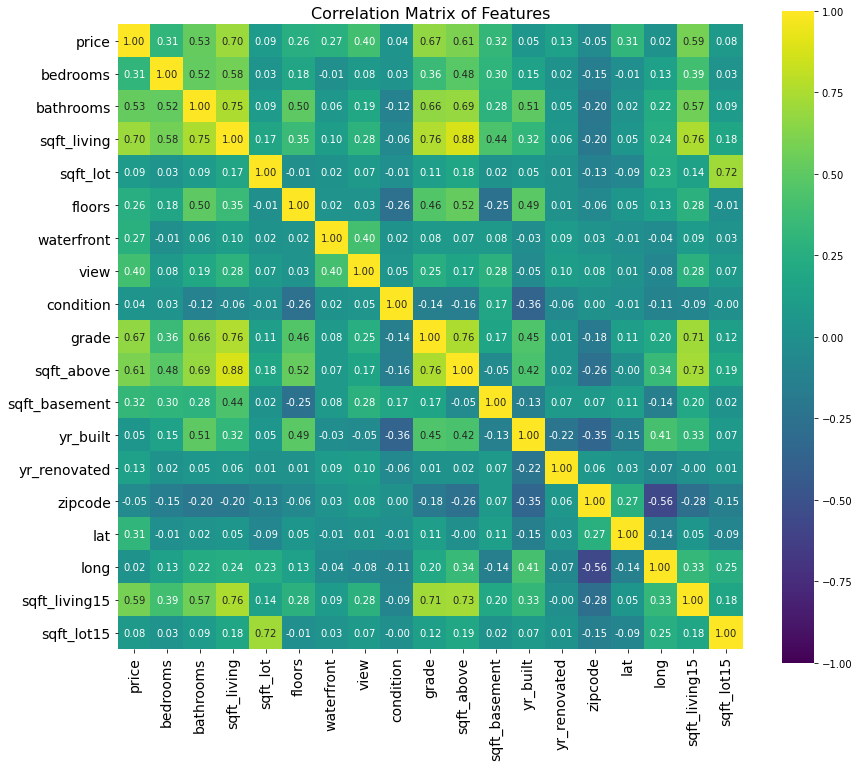

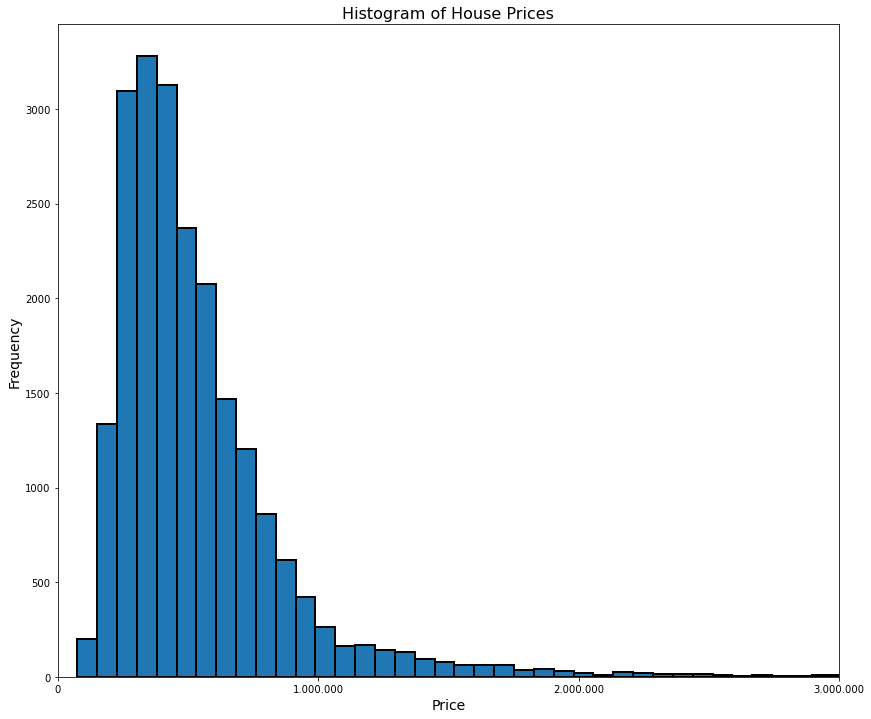

In [2]:
#Lets make a correlation matrix for all the variables

corr_matrix = house_data_clean.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', vmin=-1, vmax=1, square=True)

plt.title('Correlation Matrix of Features', fontsize=16)
#Make x any y labels bigger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('corr_matrix.pdf')
plt.show()

#Now we can also make a simple histogram of the price distribution to see if we might be biased in our predictions
plt.figure(figsize=(14, 12))
plt.hist(house_data_clean['price'], bins=100, edgecolor='black', linewidth=2)
plt.title('Histogram of House Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0,3e6)
plt.xticks([0, 1e6, 2e6, 3e6], ['0', '1.000.000', '2.000.000', '3.000.000'])
plt.savefig('price_hist.pdf')


Try linear regression to predict house prices, and find the root mean squared error and r2 value

In [3]:
# Initialize a linear regression model
linear_reg = LinearRegression()

# Fit the model to the training data
linear_reg.fit(X_train, y_train)

# Predict the prices on the test set
y_pred = linear_reg.predict(X_test)

# Calculate and return the RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2


#Now do the same but with cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Initialize a 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a linear regression model
linear_reg = LinearRegression()

# Perform a 5-fold cross-validation
#also time it
import time
start_time = time.time()
cv_results = cross_val_score(linear_reg, X, y, cv=kf, scoring='r2')
print("--- %s seconds ---" % (time.time() - start_time))
# Calculate the mean score across fold

cv_score = np.mean(cv_results)
print(cv_results)
print(np.mean(cv_results), 'Average R2 score for linear regression')

from sklearn.tree import DecisionTreeRegressor
DT_reg = DecisionTreeRegressor(random_state=42)

#time the decision tree
start_time = time.time()
cv_results_DT1 = cross_val_score(DT_reg, X, y, cv=kf, scoring='r2')
print("--- %s seconds ---" % (time.time() - start_time))
print(np.mean(cv_results_DT1), 'Average R2 score for Decision Tree regression')


--- 0.041907310485839844 seconds ---
[0.70119044 0.68597027 0.69547324 0.70465746 0.7062373 ]
0.698705743649674 Average R2 score for linear regression
--- 0.778325080871582 seconds ---
0.7537745695873935 Average R2 score for Decision Tree regression


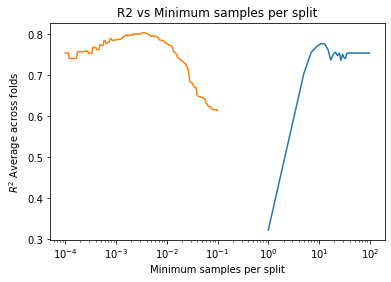

In [4]:
#now lets try decision tree, where we vary the minimum number of samples per leaf

ls = []
for N in (x := np.arange(1,100, 2)):
    DT = DecisionTreeRegressor(random_state=42, max_depth= N)
    DT.fit(X_train, y_train)
    y_pred = DT.predict(X_test)
    cv_results_DT = cross_val_score(DT, X, y, cv=kf, scoring='r2')
    #print(cv_results_DT)
    ls.append(np.mean(cv_results_DT))

ls = np.array(ls)
plt.plot(x, ls)
plt.xlabel('Maximum depth of tree')
plt.ylabel(r'$R^2$ Average across folds')
plt.title('R2 vs Maximum depth of tree')
#plt.xscale('log')
plt.savefig('max_depth.pdf')

ls = []
for N in (x := np.logspace(-4,-1,150)):
    DT = DecisionTreeRegressor(random_state=42, min_samples_split= N)
    DT.fit(X_train, y_train)
    y_pred = DT.predict(X_test)
    cv_results_DT = cross_val_score(DT, X, y, cv=kf, scoring='r2')
    #print(cv_results_DT)
    ls.append(np.mean(cv_results_DT))

ls = np.array(ls)
plt.plot(x, ls)
plt.xlabel('Minimum samples per split')
plt.ylabel(r'$R^2$ Average across folds')
plt.title('R2 vs Minimum samples per split')
plt.xscale('log')
plt.savefig('min_samples_split.pdf')


Try the same but with random forest, this one works way better

In [5]:
from sklearn.ensemble import RandomForestRegressor


random_forest = RandomForestRegressor(random_state=42)

# Fit the model to the training data
random_forest.fit(X_train, y_train)

# Predict the prices on the test set
y_pred_rf = random_forest.predict(X_test)

# Calculate and return the RMSE and R^2 for Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)



print(rmse_rf, r2_rf)

#Now do ti with cross validation
start_time = time.time()
cv_results_rf = cross_val_score(random_forest, X, y, cv=kf, scoring='r2')
print("--- %s seconds ---" % (time.time() - start_time))
print(np.mean(cv_results_rf))



148582.89939799326 0.8539664101438819
--- 44.85616874694824 seconds ---
0.8789543527355415


Question 2: define bins and see if we split somewhat well

In [6]:
# Define bins and labels for classification
bins = [0, 300000, 400000, 500000, 700000, np.inf]
labels = ['Very Cheap', 'Cheap', 'Average', 'Expensive', 'Very Expensive']

# Assign labels to each instance
house_data_clean['price_category'] = pd.cut(house_data_clean['price'], bins=bins, labels=labels, right=False)

# Check the distribution of the new price categories
price_category_distribution = house_data_clean['price_category'].value_counts(normalize=True).sort_index()

price_category_distribution


Very Cheap        0.205293
Cheap             0.196965
Average           0.171841
Expensive         0.221765
Very Expensive    0.204136
Name: price_category, dtype: float64

sure, good enough, now lets classify using logistic regression, one vs all first

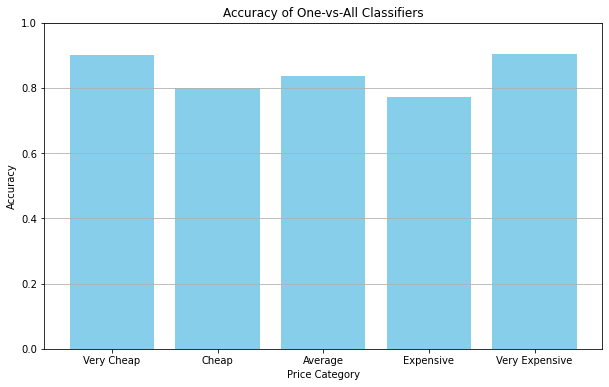

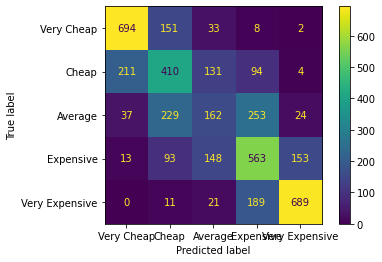

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract features and labels
X = house_data_clean.drop(columns=['price', 'price_category'])
y = house_data_clean['price_category']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a standard scaler and apply it to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize results storage
ova_results = {
    'category': [],
    'accuracy': [],
    'classification_report': []
}

# Train logistic regression models for each category
for category in labels:
    # Binary labels: 1 for the current category, 0 for all others
    y_train_binary = (y_train == category).astype(int)
    y_test_binary = (y_test == category).astype(int)
    
    # Initialize and train the logistic regression model
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train_scaled, y_train_binary)
    
    # Predictions
    y_pred = log_reg.predict(X_test_scaled)
    
    # Store results
    ova_results['category'].append(category)
    ova_results['accuracy'].append(accuracy_score(y_test_binary, y_pred))
    ova_results['classification_report'].append(classification_report(y_test_binary, y_pred))

# Visualizing accuracy for each binary classifier
plt.figure(figsize=(10, 6))
plt.bar(ova_results['category'], ova_results['accuracy'], color='skyblue')
plt.xlabel('Price Category')
plt.ylabel('Accuracy')
plt.title('Accuracy of One-vs-All Classifiers')
plt.ylim([0, 1])
plt.grid(axis='y')
plt.show()

# Displaying accuracy and classification reports
ova_results['accuracy'], ova_results['classification_report']

# Step 2: Confusion Matrix for OvA

# Train a logistic regression model directly for multiclass (OvA strategy internally)

log_reg_multiclass = LogisticRegression(random_state=42)

log_reg_multiclass.fit(X_train_scaled, y_train)



# Predictions

y_pred_ova = log_reg_multiclass.predict(X_test_scaled)



# Confusion matrix

conf_matrix_ova = confusion_matrix(y_test, y_pred_ova, labels=labels)



# Displaying confusion matrix

ConfusionMatrixDisplay(conf_matrix_ova, display_labels=labels).plot(values_format=".0f")


Now we do One vs One

(0.5850104094378904,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x24b8d6ed2e0>)

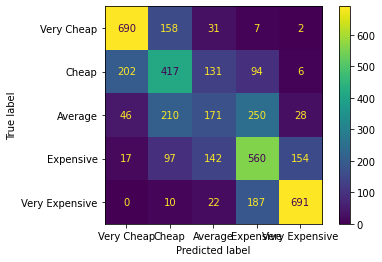

In [8]:
from sklearn.multiclass import OneVsOneClassifier


# Initialize and train the OvO classifier
ovo_classifier = OneVsOneClassifier(LogisticRegression(random_state=42))
ovo_classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred_ovo = ovo_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
conf_matrix_ovo = confusion_matrix(y_test, y_pred_ovo, labels=labels)

# Displaying accuracy and confusion matrix
accuracy_ovo, ConfusionMatrixDisplay(conf_matrix_ovo, display_labels=labels).plot(values_format=".0f")


Q3 Apply boosting to any classifier you used, i will use it on linear regression

In [9]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Step 1: Base Regressor - Linear Regression
# Note: We switch back to regression, using the original 'price' as the target
lr_regressor = LinearRegression()
lr_cv_scores = cross_val_score(lr_regressor, X, house_data_clean['price'], cv=5, scoring='neg_root_mean_squared_error')

# Step 2: Boosted Regressor - AdaBoost with Linear Regression
# Define different numbers of estimators to be evaluated
n_estimators_list = [5, 10, 15, 20, 25]

# Initialize storage for mean and std of RMSE for different numbers of estimators
boosted_rmse_mean = []
boosted_rmse_std = []

# Evaluate AdaBoost with different numbers of estimators using cross-validation
for n_estimators in n_estimators_list:
    ada_boost = AdaBoostRegressor(
        LinearRegression(),
        n_estimators=n_estimators,
        random_state=42
    )
    ada_cv_scores = cross_val_score(ada_boost, X, house_data_clean['price'], cv=5, scoring='neg_root_mean_squared_error')
    boosted_rmse_mean.append(np.mean(ada_cv_scores))
    boosted_rmse_std.append(np.std(ada_cv_scores))

# Results: Base Regressor (Linear Regression) and Boosted Regressor (AdaBoost with LR)
lr_cv_scores.mean(), lr_cv_scores.std(), boosted_rmse_mean, boosted_rmse_std
print(f'Base RMSE: {-lr_cv_scores.mean():.2f} +/- {lr_cv_scores.std():.2f}')
print(f'Boosted for 10 estimators: {-boosted_rmse_mean[0]:.2f} +/- {boosted_rmse_std[0]:.2f}')
print(f'Boosted for 50 estimators: {-boosted_rmse_mean[1]:.2f} +/- {boosted_rmse_std[1]:.2f}')
print(f'Boosted for 100 estimators: {-boosted_rmse_mean[2]:.2f} +/- {boosted_rmse_std[2]:.2f}')
print(f'Boosted for 150 estimators: {-boosted_rmse_mean[3]:.2f} +/- {boosted_rmse_std[3]:.2f}')
print(f'Boosted for 200 estimators: {-boosted_rmse_mean[4]:.2f} +/- {boosted_rmse_std[4]:.2f}')



Base RMSE: 202532.92 +/- 9731.39
Boosted for 10 estimators: 241616.16 +/- 14304.95
Boosted for 50 estimators: 288181.60 +/- 18658.39
Boosted for 100 estimators: 286968.83 +/- 17370.84
Boosted for 150 estimators: 286925.71 +/- 17342.91
Boosted for 200 estimators: 286914.39 +/- 17349.41


So for some reason linear regression becomes worse when boosted. Quite odd tbh. Lets try boosting a normal decision tree now:

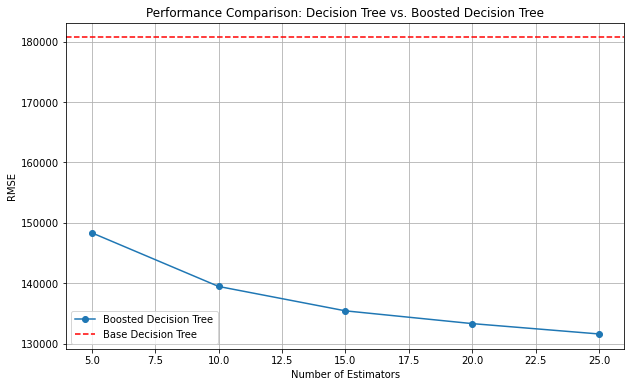

(-180698.89406838382,
 4095.364152818807,
 [-148342.18170209258,
  -139456.81646638375,
  -135419.9706942736,
  -133305.56207820273,
  -131589.0964175475],
 [7324.0692380734645,
  10594.113032390704,
  8708.20457485151,
  8891.332844667462,
  7202.377827591134])

In [10]:
from sklearn.tree import DecisionTreeRegressor

# Step 1: Base Regressor - Decision Tree
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_cv_scores = cross_val_score(dt_regressor, X, house_data_clean['price'], cv=5, scoring='neg_root_mean_squared_error')

# Step 2: Boosted Regressor - AdaBoost with Decision Tree
# Initialize storage for mean and std of RMSE for different numbers of estimators
boosted_dt_rmse_mean = []
boosted_dt_rmse_std = []
r2_dt = []

# Evaluate AdaBoost with different numbers of estimators using cross-validation
for n_estimators in n_estimators_list:
    ada_boost_dt = AdaBoostRegressor(
        DecisionTreeRegressor(random_state=42),
        n_estimators=n_estimators,
        random_state=42
    )
    ada_cv_scores_dt = cross_val_score(ada_boost_dt, X, house_data_clean['price'], cv=5, scoring='neg_root_mean_squared_error')
    boosted_dt_rmse_mean.append(np.mean(ada_cv_scores_dt))
    boosted_dt_rmse_std.append(np.std(ada_cv_scores_dt))

# Step 3: Visualization & Comparison
# Plotting RMSE for Base and Boosted Decision Tree with varying n_estimators
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, [-x for x in boosted_dt_rmse_mean], marker='o', label='Boosted Decision Tree', linestyle='-')
plt.axhline(y=-dt_cv_scores.mean(), color='r', linestyle='--', label='Base Decision Tree')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('Performance Comparison: Decision Tree vs. Boosted Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

# Results: Base Regressor (Decision Tree) and Boosted Regressor (AdaBoost with DT)
dt_cv_scores.mean(), dt_cv_scores.std(), boosted_dt_rmse_mean, boosted_dt_rmse_std


Q4 Apply PCA to this data to reduce dimensions to 2

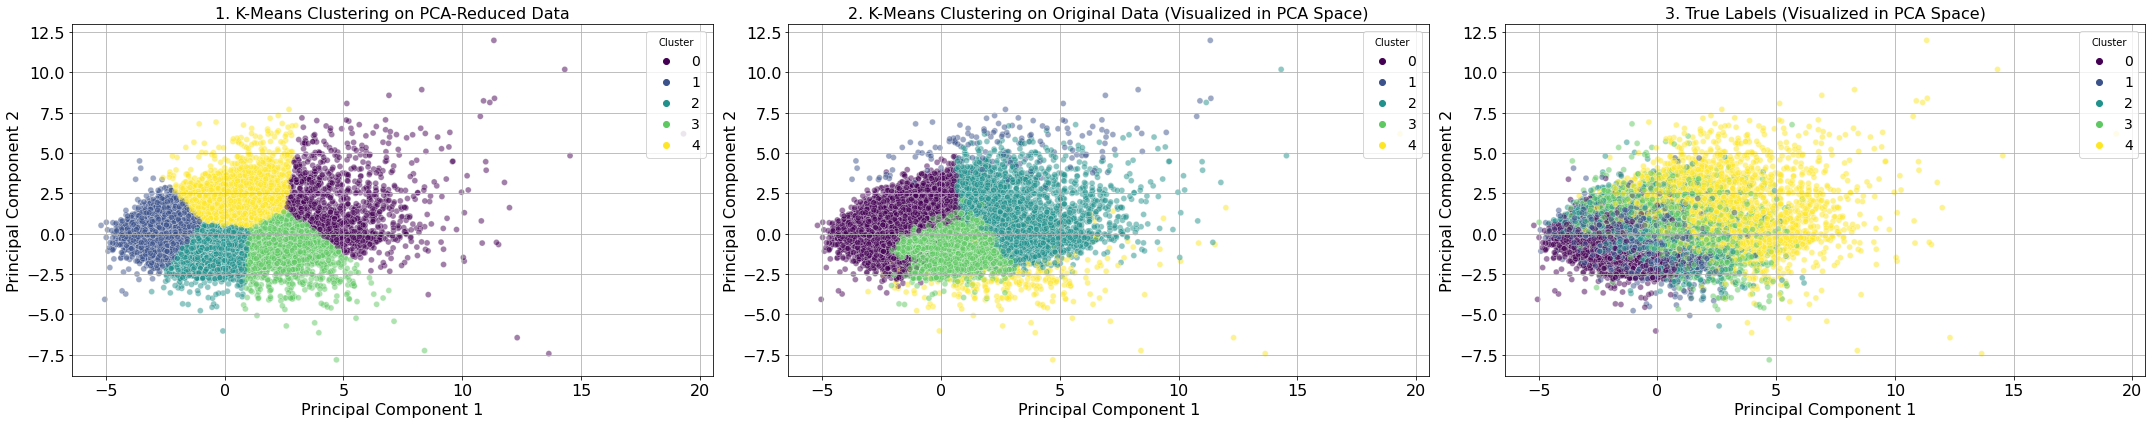

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
#import PCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reload and preprocess the data
file_path = 'HousePriceDataset.csv'
house_data = pd.read_csv(file_path)
house_data['sqft_lot15'] = house_data['sqft_lot15'].str.strip("'b'").astype(int)

# Dropping 'id' and 'Unnamed: 0' columns
house_data_clean = house_data.drop(columns=['id', 'Unnamed: 0'])

# Price categories
bins = [0, 300000, 400000, 500000, 700000, np.inf]
labels = ['Very Cheap', 'Cheap', 'Average', 'Expensive', 'Very Expensive']
house_data_clean['price_category'] = pd.cut(house_data_clean['price'], bins=bins, labels=labels)

# Data Preparation
X_pca = house_data_clean.drop(columns=['price', 'price_category'])
X_pca_scaled = StandardScaler().fit_transform(X_pca)  # Scaling the data

# PCA
pca = PCA(n_components=2)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# K-Means Clustering on PCA-reduced data
kmeans_pca = KMeans(n_clusters=5, random_state=42).fit(X_pca_transformed)
kmeans_pca_labels = kmeans_pca.labels_

# K-Means Clustering on original data
kmeans_original = KMeans(n_clusters=5, random_state=42).fit(X_pca_scaled)
kmeans_original_labels = kmeans_original.labels_


# Creating side-by-side comparison plots
plt.figure(figsize=(30, 6))

# Plot 1: Clusters formed by performing K-Means clustering on the PCA-reduced data
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_pca_transformed[:, 0], y=X_pca_transformed[:, 1], hue=kmeans_pca_labels, palette='viridis', alpha=0.5)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title('1. K-Means Clustering on PCA-Reduced Data', fontsize=16)
plt.grid(True)
plt.legend(title='Cluster', loc='upper right', fontsize = 14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Plot 2: Clusters formed by performing K-Means clustering on the original data, visualized in PCA space
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_pca_transformed[:, 0], y=X_pca_transformed[:, 1], hue=kmeans_original_labels, palette='viridis', alpha=0.5)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title('2. K-Means Clustering on Original Data (Visualized in PCA Space)', fontsize=16)
plt.grid(True)
plt.legend(title='Cluster', loc='upper right', fontsize = 14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Plot 3: True labels as shown in pca space
plt.subplot(1, 3, 3)
#Transform the price category labels to numbers 0-4
house_data_clean['price_category'] = house_data_clean['price_category'].replace({'Very Cheap': 0, 'Cheap': 1, 'Average': 2, 'Expensive': 3, 'Very Expensive': 4})
sns.scatterplot(x=X_pca_transformed[:, 0], y=X_pca_transformed[:, 1], hue=house_data_clean['price_category'], palette='viridis', alpha=0.5)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.title('3. True Labels (Visualized in PCA Space)', fontsize=16)
plt.grid(True)  
plt.legend(title='Cluster', loc='upper right', fontsize = 14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.savefig('PCA.pdf')
plt.show()



c:\Users\timov\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


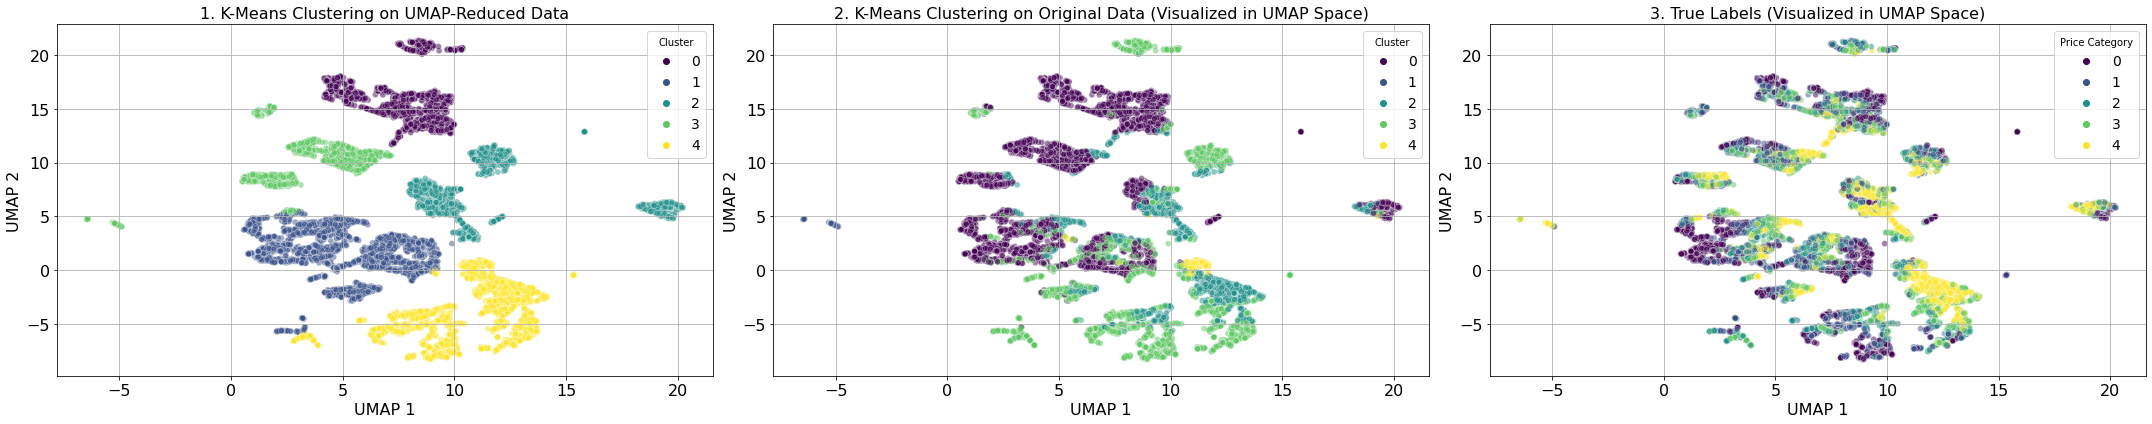

In [29]:
#Lets try to do the same but using UMAP instead of PCA
import umap.umap_ as umap

Umap_scaled = X_pca_scaled
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(Umap_scaled)

kmeans_umap = KMeans(n_clusters=5, random_state=42).fit(embedding)
kmeans_umap_labels = kmeans_umap.labels_


plt.figure(figsize=(30, 6))

# Plot 1: Clusters formed by performing K-Means clustering on the umap-reduced data
plt.subplot(1, 3, 1)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=kmeans_umap_labels, palette='viridis', alpha=0.5)
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)
plt.title('1. K-Means Clustering on UMAP-Reduced Data', fontsize=16)
plt.grid(True)
plt.legend(title='Cluster', loc='upper right', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Plot 2: Clusters formed by performing K-Means clustering on the original data, visualized in UMAP space
plt.subplot(1, 3, 2)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=kmeans_original_labels, palette='viridis', alpha=0.5)
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)
plt.title('2. K-Means Clustering on Original Data (Visualized in UMAP Space)', fontsize=16)
plt.grid(True)
plt.legend(title='Cluster', loc='upper right', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Plot 3: True labels as shown in UMAP space
plt.subplot(1, 3, 3)
#Transform the price category labels to numbers 0-4
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=house_data_clean['price_category'], palette='viridis', alpha=0.5)
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)
plt.title('3. True Labels (Visualized in UMAP Space)', fontsize=16)
plt.grid(True)
plt.legend(title='Price Category', loc='upper right', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.tight_layout()
plt.savefig('UMAP.pdf')
plt.show()


still q4: lets make a confucius matrix 

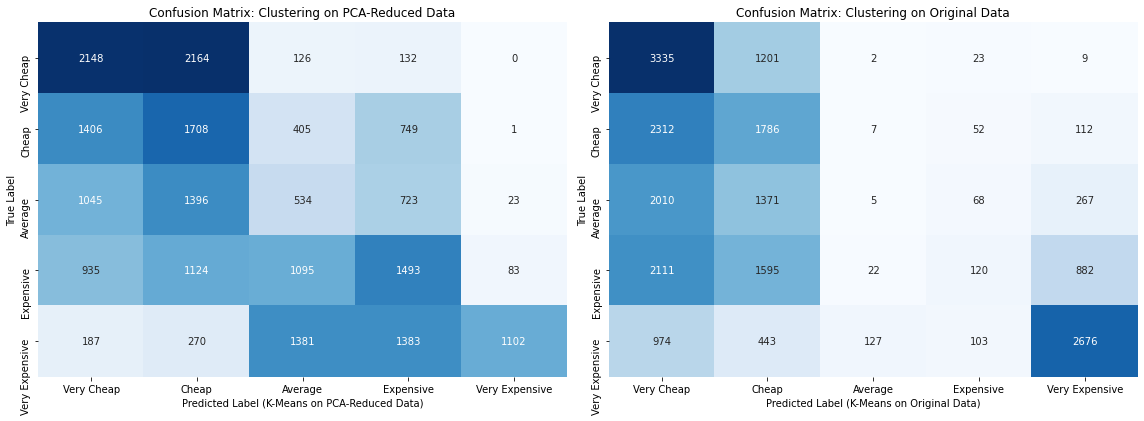

(array([[2148, 2164,  126,  132,    0],
        [1406, 1708,  405,  749,    1],
        [1045, 1396,  534,  723,   23],
        [ 935, 1124, 1095, 1493,   83],
        [ 187,  270, 1381, 1383, 1102]], dtype=int64),
 array([[3335, 1201,    2,   23,    9],
        [2312, 1786,    7,   52,  112],
        [2010, 1371,    5,   68,  267],
        [2111, 1595,   22,  120,  882],
        [ 974,  443,  127,  103, 2676]], dtype=int64))

In [ ]:

from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns

# Encoding the price categories for confusion matrix
category_encoding = {category: i for i, category in enumerate(labels)}
true_labels = house_data_clean['price_category'].map(category_encoding).values

# Function to align cluster labels with true labels (to minimize confusion matrix cost)
def align_cluster_labels(true_labels, cluster_labels):
    conf_mat = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)  # Maximizing the confusion matrix entries
    label_mapping = dict(zip(col_ind, row_ind))
    aligned_labels = np.vectorize(label_mapping.get)(cluster_labels)
    return aligned_labels

# Aligning cluster labels for meaningful comparison in confusion matrices
aligned_labels_pca = align_cluster_labels(true_labels, kmeans_pca_labels)
aligned_labels_original = align_cluster_labels(true_labels, kmeans_original_labels)

# Compute confusion matrices
conf_mat_pca = confusion_matrix(true_labels, aligned_labels_pca)
conf_mat_original = confusion_matrix(true_labels, aligned_labels_original)

# Create side-by-side confusion matrix plots
plt.figure(figsize=(16, 6))

# Plot 1: Confusion Matrix for Clusters from PCA-Reduced Data
plt.subplot(1, 2, 1)
sns.heatmap(conf_mat_pca, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label (K-Means on PCA-Reduced Data)')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Clustering on PCA-Reduced Data')

# Plot 2: Confusion Matrix for Clusters from Original Data
plt.subplot(1, 2, 2)
sns.heatmap(conf_mat_original, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label (K-Means on Original Data)')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Clustering on Original Data')

plt.tight_layout()
plt.show()

# Results: Confusion matrices
conf_mat_pca, conf_mat_original


Q5 chatgpt tries decision tree gradient boosting error to beat $130K

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preparing the data
X = house_data_clean.drop(columns=['price', 'price_category'])
y = house_data_clean['price']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuring a Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(random_state=42)

# Defining a parameter grid to explore
param_grid = {
    'n_estimators': [5, 15, 25],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}

# Setting up GridSearchCV
grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fitting the model
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_gb_model = grid_search.best_estimator_

# Predictions
y_train_pred = best_gb_model.predict(X_train)
y_test_pred = best_gb_model.predict(X_test)

# Evaluation: RMSE, MAE, and R^2
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Results
best_params, (rmse_train, rmse_test), (mae_train, mae_test), (r2_train, r2_test)
print(f'RMSE (train): {rmse_train:.2f}')
print(f'RMSE (test): {rmse_test:.2f}')
print(f'MAE (train): {mae_train:.2f}')
print(f'MAE (test): {mae_test:.2f}')
print(f'R^2 (train): {r2_train:.2f}')
print(f'R^2 (test): {r2_test:.2f}')


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   13.3s finished


RMSE (train): 78645.98
RMSE (test): 144065.73
MAE (train): 53942.48
MAE (test): 73582.61
R^2 (train): 0.95
R^2 (test): 0.86


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Base models
base_models = [
    ('linear_reg', LinearRegression()),
    ('dt_reg', DecisionTreeRegressor(random_state=42)),
    ('gb_reg', GradientBoostingRegressor(
        n_estimators=50, max_depth=8, learning_rate=0.1, subsample=1.0, random_state=42))  # using previously tuned parameters
]

# Meta-model
meta_model = LinearRegression()

# Stacking Regressor
stacking_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=8, n_jobs=-1)

# Fitting the model
stacking_reg.fit(X_train, y_train)

# Predictions
y_train_pred_stack = stacking_reg.predict(X_train)
y_test_pred_stack = stacking_reg.predict(X_test)

# Evaluation: RMSE, MAE, and R^2
rmse_train_stack = np.sqrt(mean_squared_error(y_train, y_train_pred_stack))
rmse_test_stack = np.sqrt(mean_squared_error(y_test, y_test_pred_stack))
mae_train_stack = mean_absolute_error(y_train, y_train_pred_stack)
mae_test_stack = mean_absolute_error(y_test, y_test_pred_stack)
r2_train_stack = r2_score(y_train, y_train_pred_stack)
r2_test_stack = r2_score(y_test, y_test_pred_stack)

# Results
(rmse_train_stack, rmse_test_stack), (mae_train_stack, mae_test_stack), (r2_train_stack, r2_test_stack)


((63156.087433489716, 142994.43116906352),
 (44961.08078741477, 71620.90239350926),
 (0.9694700826488114, 0.8647449925315024))

(14,
 array([0.29050072, 0.4127982 , 0.51528953, 0.59116944, 0.65814264,
        0.7138638 , 0.76237696, 0.8088325 , 0.84535441, 0.87874916,
        0.90645033, 0.92892108, 0.9469671 , 0.96281801]))

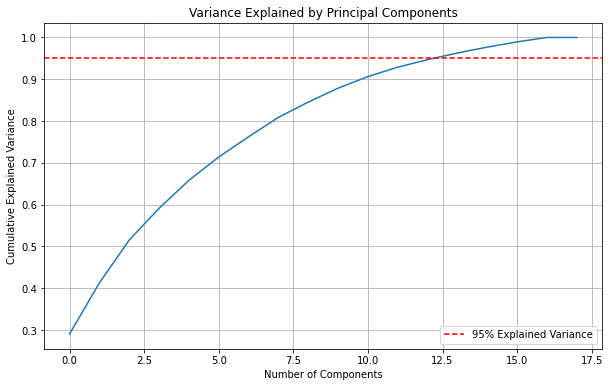

In [ ]:
# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA and explained variance
pca_all = PCA().fit(X_scaled)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained by Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend(loc='lower right')
plt.grid(True)

# Results
explained_variance_95 = np.where(np.cumsum(pca_all.explained_variance_ratio_) >= 0.95)[0][0] + 1  # +1 to adjust for 0-indexing
explained_variance_95, np.cumsum(pca_all.explained_variance_ratio_)[:explained_variance_95]


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# PCA for 14 components
pca_14 = PCA(n_components=14)
X_pca_14 = pca_14.fit_transform(X_scaled)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_pca_14, y, test_size=0.2, random_state=42)

# Base model: Decision Tree
dt_reg = DecisionTreeRegressor(random_state=42)

# AdaBoost model
ada_reg = AdaBoostRegressor(base_estimator=dt_reg, n_estimators=50, random_state=42)

# Fit the model
ada_reg.fit(X_train, y_train)

# Predictions
y_train_pred_ada = ada_reg.predict(X_train)
y_test_pred_ada = ada_reg.predict(X_test)

# Evaluation: RMSE, MAE, and R^2
rmse_train_ada = np.sqrt(mean_squared_error(y_train, y_train_pred_ada))
rmse_test_ada = np.sqrt(mean_squared_error(y_test, y_test_pred_ada))
mae_train_ada = mean_absolute_error(y_train, y_train_pred_ada)
mae_test_ada = mean_absolute_error(y_test, y_test_pred_ada)
r2_train_ada = r2_score(y_train, y_train_pred_ada)
r2_test_ada = r2_score(y_test, y_test_pred_ada)

# Cross-validation for stability check
cv_scores_ada = cross_val_score(ada_reg, X_pca_14, y, cv=5, scoring='neg_root_mean_squared_error')
mean_cv_score_ada = np.mean(-cv_scores_ada)

# Results
(rmse_train_ada, rmse_test_ada), (mae_train_ada, mae_test_ada), (r2_train_ada, r2_test_ada), mean_cv_score_ada


((16162.551123546718, 180030.86571792056),
 (5548.456300043405, 86739.0341644762),
 (0.9980005294253146, 0.7856077690320723),
 158214.22571854718)